# Amharic Speech Recognition with Neural Networks


In [102]:

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import sys
import os

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
import pandas as pd
import  muda
import jams
from matplotlib import pyplot as plt
import librosa 

%matplotlib inline
sys.path.append(os.path.abspath(os.path.join('..')))

from scr.audio_explorer import AudioExplorer


In [103]:
ae = AudioExplorer('../data/train')

AudioExplorer:INFO->Successfully Created AudioExplorer Class
AudioExplorer:INFO->Successfully Loaded Audio and TTS files


In [104]:
ae

# Get Information Dataframe

In [105]:
info_df = ae.get_audio_info()
info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             83 non-null     object 
 1   Channel          83 non-null     object 
 2   Duration(sec)    83 non-null     float64
 3   Frequency(Hz)    83 non-null     int64  
 4   MinAmplitude     83 non-null     float64
 5   MaxAmplitude     83 non-null     float64
 6   AmplitudeMean    83 non-null     float64
 7   AmplitudeMedian  83 non-null     float64
 8   HasTTS           83 non-null     bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 5.4+ KB


In [106]:
# Get a sample of the dataframe
info_df.sample(10)

,Name,Channel,Duration(sec),Frequency(Hz),MinAmplitude,MaxAmplitude,AmplitudeMean,AmplitudeMedian,HasTTS
22,tr_9924_tr097006,Stereo,7.059,16000,-0.424,0.092,-0.125,-0.125,True
24,tr_9926_tr097008,Stereo,2.972,16000,-0.576,0.255,-0.125,-0.126,True
59,tr_9980_tr097062,Stereo,2.508,16000,-0.662,0.261,-0.125,-0.126,True
36,tr_9937_tr097019,Stereo,3.622,16000,-0.674,0.325,-0.125,-0.125,True
21,tr_9923_tr097005,Stereo,6.594,16000,-0.477,0.256,-0.124,-0.125,True
65,tr_9986_tr097068,Stereo,2.972,16000,-0.810,0.396,-0.125,-0.126,True
71,tr_9991_tr097073,Stereo,3.808,16000,-0.715,0.356,-0.125,-0.126,True
82,tr_9_tr01009,Stereo,5.944,16000,-0.030,0.015,-0.005,-0.005,True
48,tr_9948_tr097030,Stereo,4.087,16000,-0.750,0.477,-0.125,-0.125,True
9,tr_9912_tr096114,Stereo,2.136,16000,-1.000,0.986,-0.124,-0.126,True


<AxesSubplot:title={'center':'Channel Types'}, xlabel='Channel', ylabel='Number of Audio-Files'>

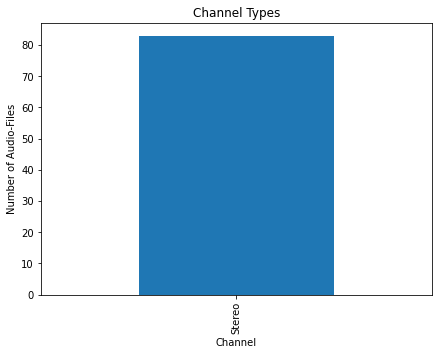

In [107]:
# Check channel types
info_df.Channel.value_counts().plot(kind='bar', title='Channel Types', ylabel='Number of Audio-Files', xlabel='Channel', figsize=(7,5))

<AxesSubplot:title={'center':'Frequency Types'}, xlabel='Frequency', ylabel='Number of Audio-Files'>

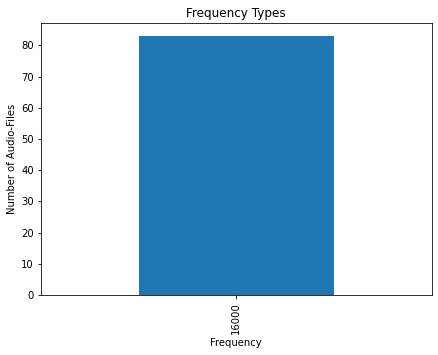

In [8]:
# Check frequency Types
info_df['Frequency(Hz)'].value_counts().plot(kind='bar', title='Frequency Types',
                                    ylabel='Number of Audio-Files', xlabel='Frequency', figsize=(7, 5))


<AxesSubplot:title={'center':'Translation Diagram'}, xlabel='Has Translation', ylabel='Number of Audio-Files'>

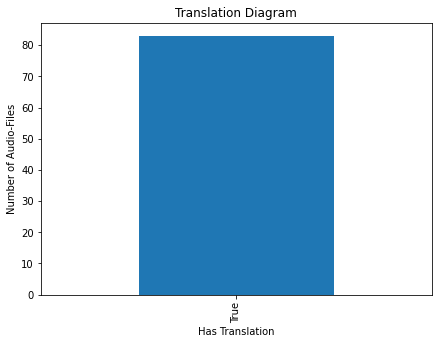

In [9]:
# Check frequency Types
info_df['HasTTS'].value_counts().plot(kind='bar', title='Translation Diagram',
                                             ylabel='Number of Audio-Files', xlabel='Has Translation', figsize=(7, 5))


In [14]:
# Grouping based on duration of audio
bins = pd.cut(info_df['Duration(sec)'], np.arange(
    0, int(max(info_df['Duration(sec)'].tolist())) + 1))
info_df.groupby(bins)['Duration(sec)'].agg(['count', 'sum']).sort_values(by='count', ascending=False)


,count,sum
Duration(sec),,
"(3, 4]",19,66.319
"(2, 3]",15,37.430
"(4, 5]",14,60.559
"(6, 7]",10,64.922
"(5, 6]",9,49.319
"(1, 2]",6,10.868
"(7, 8]",6,44.768
"(9, 10]",2,19.690
"(8, 9]",1,8.266


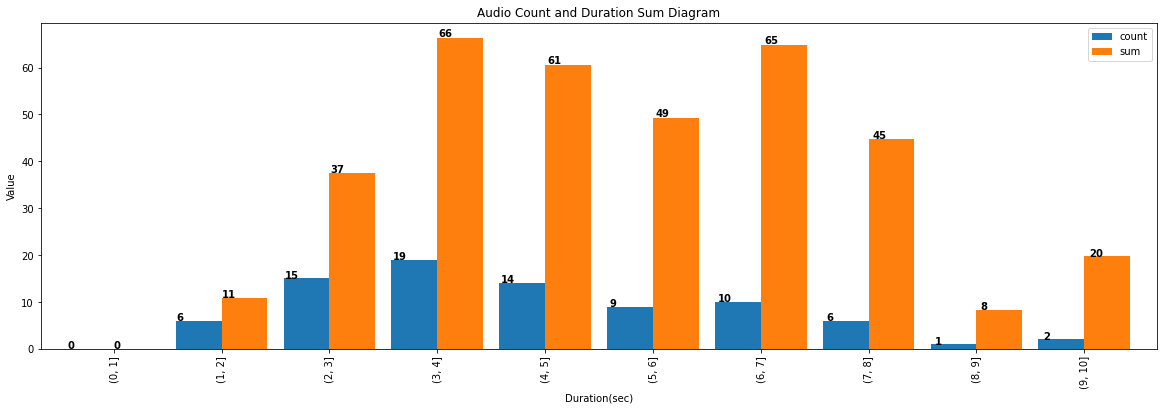

In [15]:
plot = info_df.groupby(bins)['Duration(sec)'].agg(['count', 'sum']).plot(kind='bar', width=0.85, title='Audio Count and Duration Sum Diagram',
                                                                  ylabel='Value', figsize=(20, 6))
for p in plot.patches:
    plot.annotate('{:.0f}'.format(p.get_height()), (p.get_x()
                                                   * 1.005, p.get_height() * 1.005), fontweight='bold')

In [25]:
sample_audio, sr = ae.get_audio_file(1)
ipd.Audio(sample_audio, rate=sr)

In [18]:
ae.get_tts()

{'tr_1_tr01001': 'ያንደኛ ደረጃ ትምህርታቸው ን ጐንደር ተ ም ረዋል',
 'tr_2_tr01002': 'የተ ለቀቁት ምርኮኞች በ አካባቢያቸው ሰላማዊ ኑሮ እንዲ ኖሩ የ ትራንስፖርት ና መጓጓዣ ገንዘብ ተሰጥቷ ቸው መሸኘታቸው ን አመልክቶ በ የ ዞ ናቸው እንደ ደረሱ መቃቋሚያ እንደሚ ሰጣቸው ም አስ ታውቋል',
 'tr_3_tr01003': 'በ አዲስ አበባው ስታዲየም በ ተካሄዱ ት ሁለት ግጥሚያ ዎች በ መጀመሪያ የ ተገናኙ ት መድን ና ሙገር ሲሚንቶ ሲ ሆኑ በ ውጤቱ ም ሶስት ለ ሶስት ተለያይ ተዋል',
 'tr_4_tr01004': 'ወሬው ን ወሬ ያደረጉ ምስጢረ ኞች ናቸው',
 'tr_5_tr01005': 'ኢትዮጵያዊ ቷ በ ብሄራዊ ባህላዊ አለባበስ ከ አለም አንደኝነት ን ተቀዳጀ ች',
 'tr_6_tr01006': 'ከ ትምክህት እንዳይ ቆጠር ብን እንጂ በ አለም ታሪክ ውስጥ በ ነጮች ያል ተረገጠ ች አገር ኢትዮጵያ ና ት',
 'tr_7_tr01007': 'እህቶቹ የኤርትራ ዜጐች ና የ ሻእቢያ ደጋፊዎች ናቸው',
 'tr_8_tr01008': 'እናንተ ም መቀበሪያ እንዳ ታጡ ተጠንቀቁ',
 'tr_9_tr01009': 'አንቶኔሊ በ አጼ ምንሊክ ፊት የ ፈጸመው ድፍረት በ ኢጣሊያ ን ምክር ቤት አስተ ቸው',
 'tr_10_tr01010': 'ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎማሲ ያቸው እስራኤል ንም ያስ ወር ፋቸው ጀመር',
 'tr_11_tr01011': 'ከ የ አቅጣጫ ው እየ ደረሷቸው ያሉ መረጃዎች አሳሳቢ ችግሮች እየ ደረሱ መሆናቸው ን የሚ ጠቁሙ መሆናቸው ን ፕሬዝዳንቱ ተናግረ ዋል',
 'tr_12_tr01012': 'ከ ማወቁ በፊት እንደ ተበጠበጠ ገበያ እንዳይ በታተን ይህ ነው አጀንዳ ችን ሌላ አጀንዳ የ ለ ንም',
 'tr_13_tr01013

In [33]:
ae.export_tts(1)

AudioExplorer:INFO->Successfully Exported Transliteration as JSON file to 1.


In [34]:
ae.check_tts_exist(1)

False

In [38]:
ae.get_audio_info().sample(10)

,Name,Channel,Duration(sec),Frequency(Hz),MinAmplitude,MaxAmplitude,AmplitudeMean,AmplitudeMedian,HasTTS
26,tr_9928_tr097010,Stereo,3.065,16000,-0.550,0.181,-0.124,-0.125,True
34,tr_9935_tr097017,Stereo,6.037,16000,-0.526,0.741,-0.124,-0.125,True
19,tr_9921_tr097003,Stereo,7.988,16000,-0.557,0.233,-0.125,-0.125,True
56,tr_9955_tr097037,Stereo,6.130,16000,-0.584,0.325,-0.125,-0.125,True
45,tr_9945_tr097027,Stereo,3.437,16000,-0.480,0.189,-0.125,-0.126,True
66,tr_9987_tr097069,Stereo,8.266,16000,-0.764,0.316,-0.125,-0.125,True
37,tr_9938_tr097020,Stereo,5.294,16000,-0.722,0.270,-0.125,-0.125,True
57,tr_9956_tr097038,Stereo,3.437,16000,-0.751,0.250,-0.125,-0.125,True
77,tr_9997_tr097079,Stereo,3.344,16000,-0.645,0.386,-0.124,-0.125,True
24,tr_9926_tr097008,Stereo,2.972,16000,-0.576,0.255,-0.125,-0.126,True


<module 'matplotlib.pyplot' from 'C:\\Users\\Smegn\\anaconda3\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

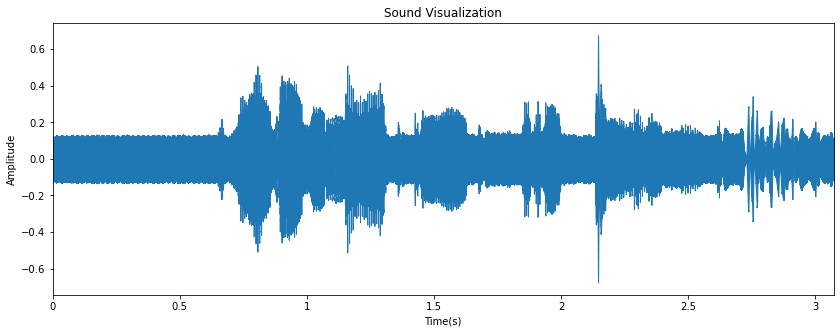

In [39]:
ae.get_audio_visualization(1)

<module 'matplotlib.pyplot' from 'C:\\Users\\Smegn\\anaconda3\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

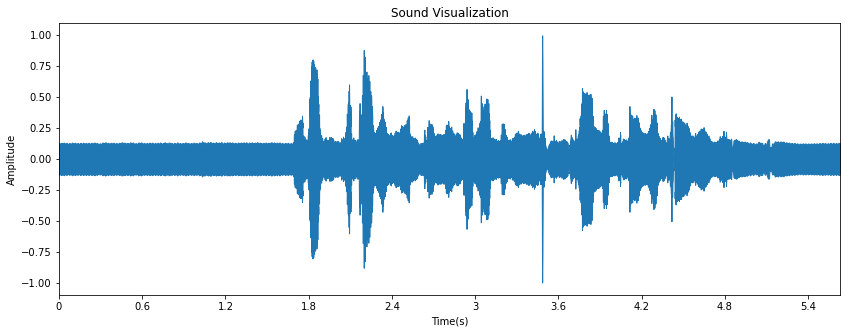

In [40]:
ae.get_audio_visualization(10)

<module 'matplotlib.pyplot' from 'C:\\Users\\Smegn\\anaconda3\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

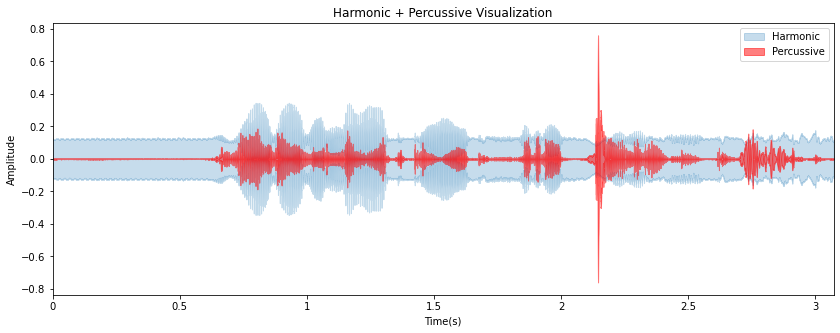

In [41]:
ae.get_harmonic_percussive_visualization(1)

<module 'matplotlib.pyplot' from 'C:\\Users\\Smegn\\anaconda3\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

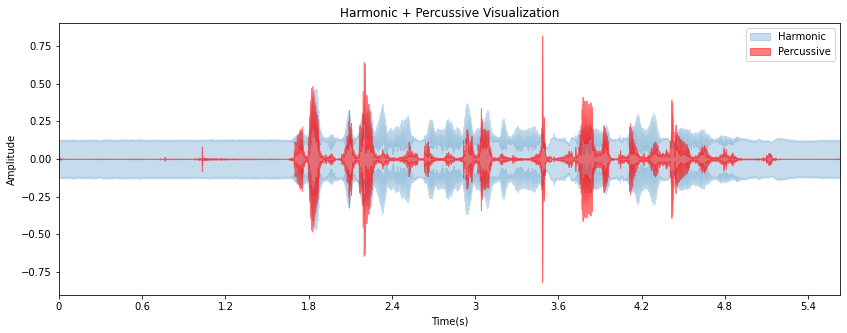

In [42]:
ae.get_harmonic_percussive_visualization(10)

<module 'matplotlib.pyplot' from 'C:\\Users\\Smegn\\anaconda3\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

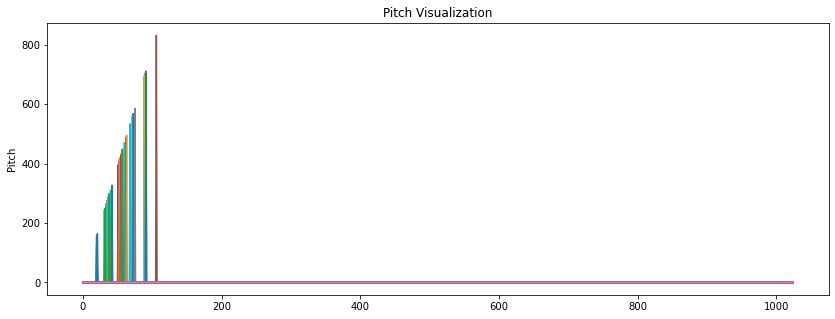

In [43]:
ae.get_pitch_visualization(1)

<module 'matplotlib.pyplot' from 'C:\\Users\\Smegn\\anaconda3\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

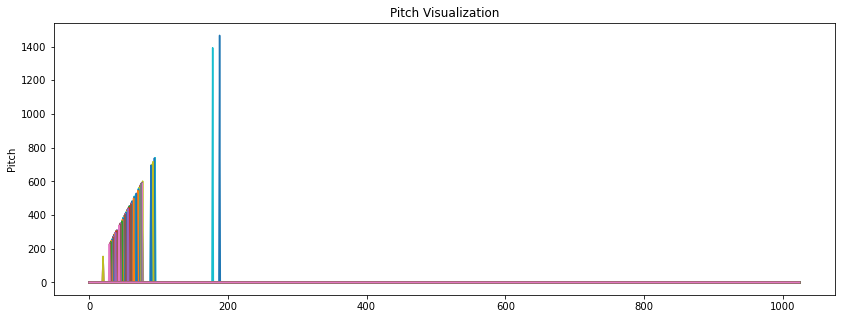

In [44]:
ae.get_pitch_visualization(10)

<module 'matplotlib.pyplot' from 'C:\\Users\\Smegn\\anaconda3\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

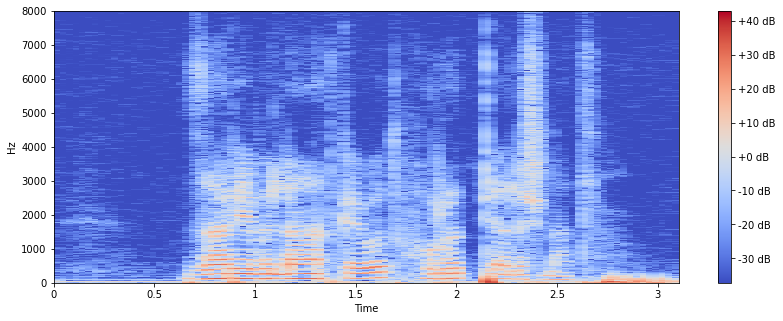

In [45]:
ae.get_spectogram_visualization(1)

<module 'matplotlib.pyplot' from 'C:\\Users\\Smegn\\anaconda3\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

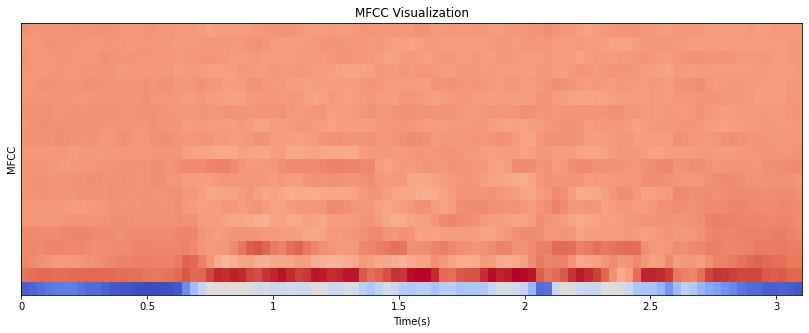

In [46]:
ae.get_mfcc_visualization(1)

<module 'matplotlib.pyplot' from 'C:\\Users\\Smegn\\anaconda3\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

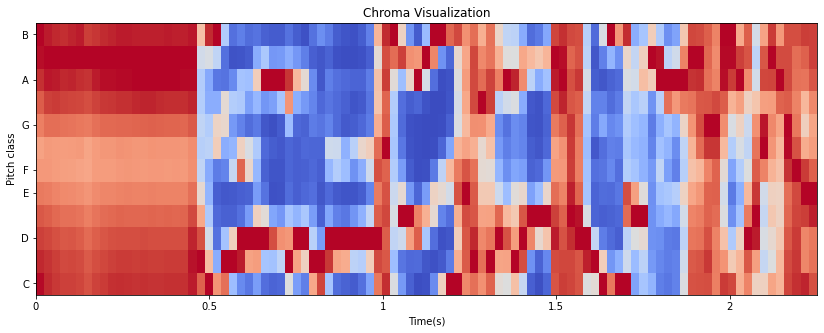

In [108]:
ae.get_chroma_visualization(1)

In [52]:
y=ae.export_tts('./translations.json')

AudioExplorer:INFO->Successfully Exported Transliteration as JSON file to ./translations.json.


# Data Agumentation

Data augmentation has been proposed as a method to generate additional training data for ASR. For example, 
artificial data was augmented for low resource speech recognition tasks. Vocal Tract Length Normalization has been adapted
for data augmentation in. Noisy audio has been synthesised via superimposing clean audio with a noisy audio signal
in . Speed perturbation has been applied on raw audio for
LVSCR tasks  . The use of an acoustic room simulator has
been explored . Data augmentation for keyword spotting
has been studied . Feature drop-outs have been employed for training multi-stream ASR systems . More generally, learned augmentation techniques have explored different
sequences of augmentation transformations that have achieved
state-of-the-art performance in the image domain (source:https://arxiv.org/pdf/1904.08779.pdf)


(https://www.kaggle.com/CVxTz/audio-data-augmentation)
Data augmentation is the process by which we create new synthetic training samples by adding small perturbations on our initial training set.
The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
In order to this to work adding the perturbations must conserve the same label as the original training sample.

In [136]:
for i in range (0, 82):
    x=ae.get_total_zero_crossing(i)
    print(x)

424
374
268
292
194
398
252
366
546
410
688
320
396
246
526
300
228
1282
242
384
312
614
586
1186
650
894
712
1382
3058
1786
880
1380
1116
2200
1458
672
906
1266
972
2578
1108
1076
1326
570
558
754
816
1906
1246
864
1198
748
880
1470
736
988
1508
726
1070
536
2458
748
1304
528
1278
868
1680
3204
2242
2138
1082
1098
2422
1134
828
1166
1272
694
2330
3746
2324
2684


(100,)

In [87]:
print(sum(zero_crossings))

0


In [88]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape

(97,)

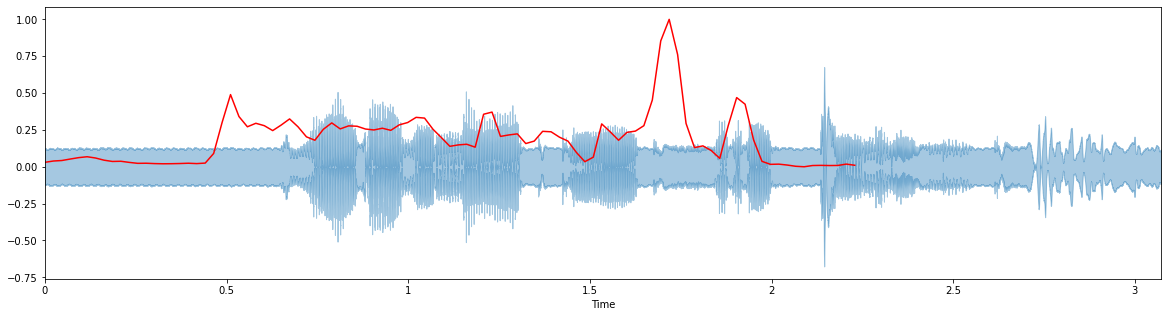

In [90]:
import sklearn
# Computing the time variable for visualization

plt.figure(figsize=(20,5))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

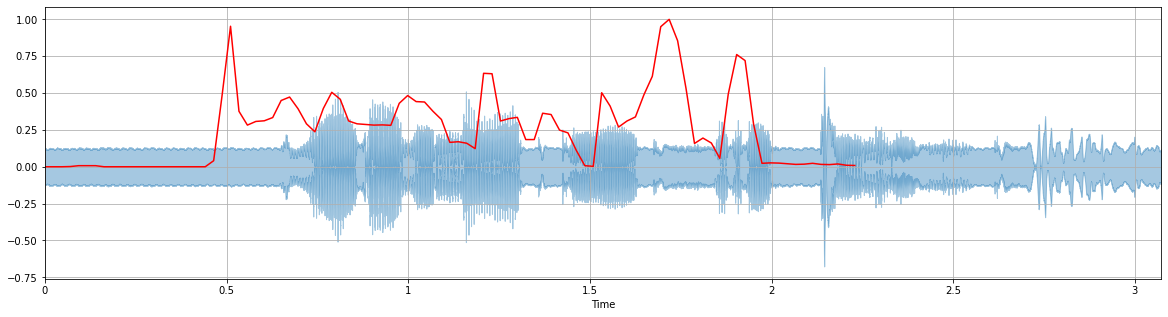

In [91]:
plt.figure(figsize=(20,5))
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.grid()

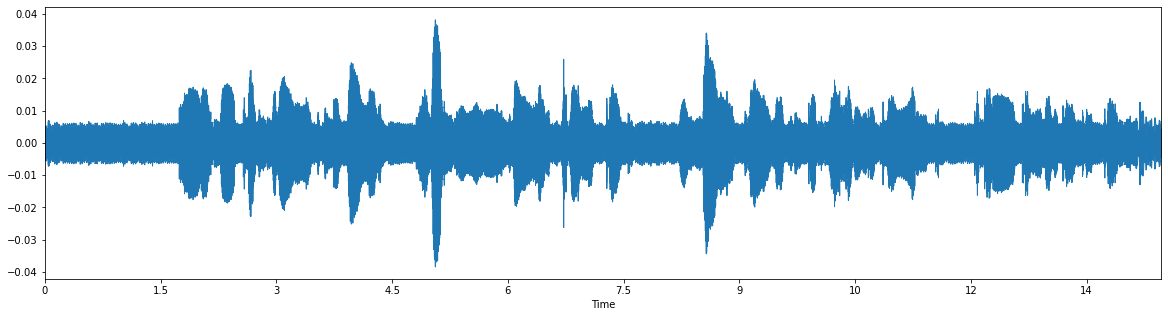

In [94]:
plt.figure(figsize=(20,5))
x, fs = librosa.load('../data/train/wav/tr_99_tr01099.wav')
librosa.display.waveplot(x, sr=sr)

(20, 453)


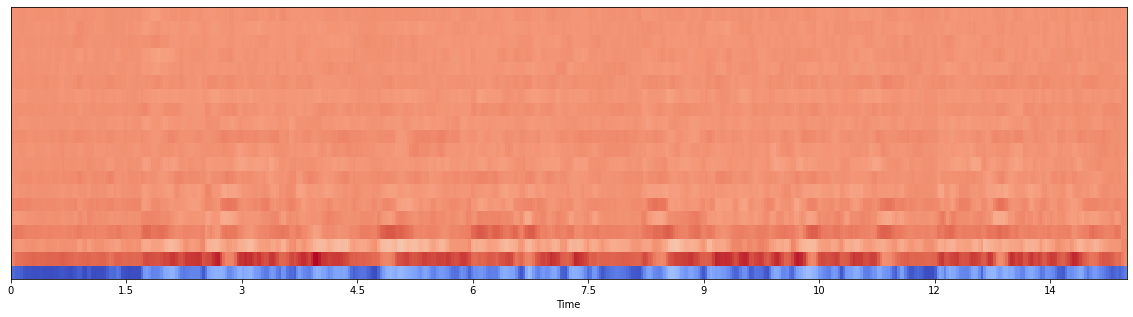

In [95]:
# MFCC
plt.figure(figsize=(20,5))
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [96]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))

[ 2.1052413e-08  1.2631448e-08 -1.4736689e-08 -8.4209653e-09
 -8.4209653e-09 -4.2104826e-09 -4.2104826e-09  0.0000000e+00
 -4.2104826e-09 -4.2104826e-09 -4.2104826e-09  0.0000000e+00
  6.3157239e-09  0.0000000e+00 -8.4209653e-09 -4.2104826e-09
  0.0000000e+00  8.4209653e-09  8.4209653e-09  2.1052413e-09]
[1.         0.9999999  1.         0.9999999  1.0000001  1.0000001
 0.9999999  1.         0.9999999  0.99999994 0.9999999  1.
 1.0000001  0.99999994 1.0000001  1.         1.0000001  1.
 1.         1.0000001 ]


C:\Users\Smegn\anaconda3\anaconda\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Smegn\anaconda3\anaconda\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


# Feature Extraction

In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [ ]:
#test some sample

In [138]:
train_audio_path = '../data//train'
filename = '/wav/tr_99_tr01099.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

Text(0.5, 0, 'Seconds')

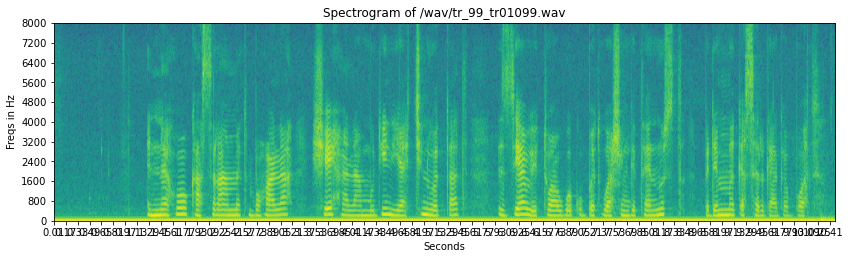

In [151]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))


ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

If we use spectrogram as an input features for NN, we have to remember to normalize features.
(We need to normalize over all the dataset, here's example just for one, which doesn't give good mean and std!)

In [146]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [154]:
len(mean)

161

We have ~160 features for each frame, frequencies are between 0 and 8000. It means, that one feature corresponds to 50 Hz.
However, frequency resolution of the ear is 3.6 Hz within the octave of 1000 – 2000 Hz It means, that people are far more precise and can hear much smaller details than those represented by spectrograms like above.

B) MFCC (Mel power spectrogram) 

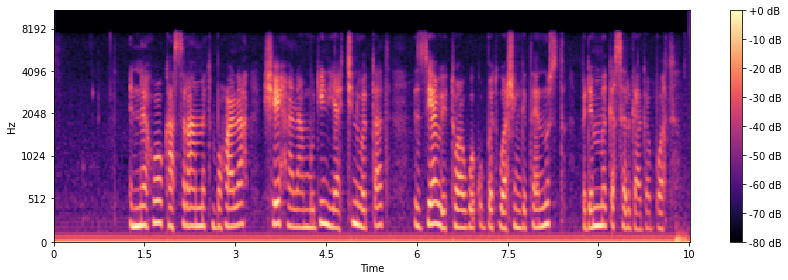

In [196]:
# sample
samples, sample_rate = librosa.load(str(train_audio_path)+filename)
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
#plt.title("Mel power spectrogram")
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

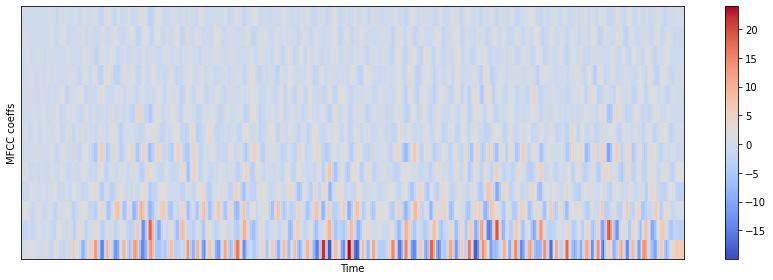

In [175]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
#plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

MFCC or similar features are taken as the input to the system instead of spectrograms.

But as you see from picture mel power spectrograms decorrelates features. However NNs deal with correlated features well.
Also, if you'll understand mel filters, you may consider their usage sensible.

# Silence removal

As you hear from the sample we have taken above, there is a silence between words. So we will use Voice Activity Detection method
can reduce training size a lot, accelerating training speed significantly. Let's cut a bit of the file from the beginning and from the end. 
and listen to it again (based on a plot above, we take from 4000 to 13000):

In [160]:
ipd.Audio(samples, rate=sample_rate)

In [177]:
samples_cut = samples[800:13000]
ipd.Audio(samples_cut, rate=sample_rate)

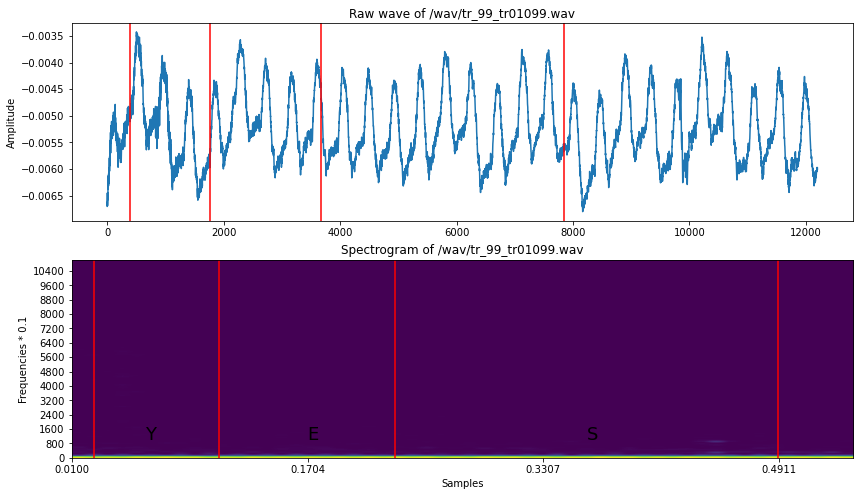

In [178]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

# Resampling - dimensionality reduction



Another way to reduce the dimensionality of our data is to resample recordings.

You can hear that the recording don't sound very natural, because they are sampled with 16k frequency, and we usually hear much more. However, the most speech related frequencies are presented in smaller band. That's why you can still understand another person talking to the telephone, where GSM signal is sampled to 8000 Hz.

Summarizing, we could resample our dataset to 8k. We will discard some information that shouldn't be important, and we'll reduce size of the data.

We have to remember that it can be risky, because this is a competition, and sometimes very small difference in performance wins, so we don't want to lost anything. On the other hand, first experiments can be done much faster with smaller training size.

We'll need to calculate FFT (Fast Fourier Transform).

In [179]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

Read some recording, resample it, and listen and compare FFT.
Notice, that there is almost no information above 4000 Hz in original signal.

In [186]:
filename = '/wav/tr_99_tr01099.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [187]:
ipd.Audio(samples, rate=sample_rate)

In [188]:
ipd.Audio(resampled, rate=new_sample_rate)

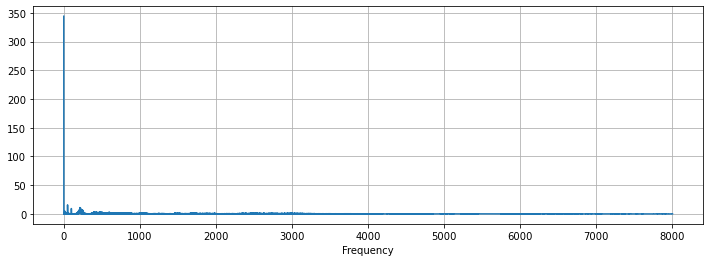

In [190]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
#plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

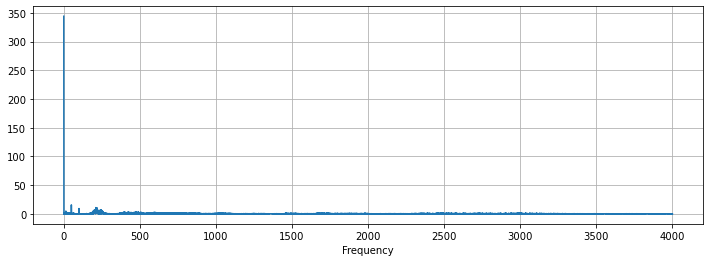

In [192]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
#plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()